In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import Input, Model
from keras.layers import Dense, Dropout, Flatten, add
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
from tensorflow.keras.applications import DenseNet201
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet169
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, Rescaling, RandomTranslation
from keras import Sequential
from tqdm import tqdm

In [2]:
root_dir = '../input/cassava-leaf-disease-classification'

train_df = pd.read_csv(os.path.join(root_dir, 'train.csv'))
print("there are " + str(train_df.shape[0]) + " train samples" )
train_df.head()

there are 21397 train samples


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


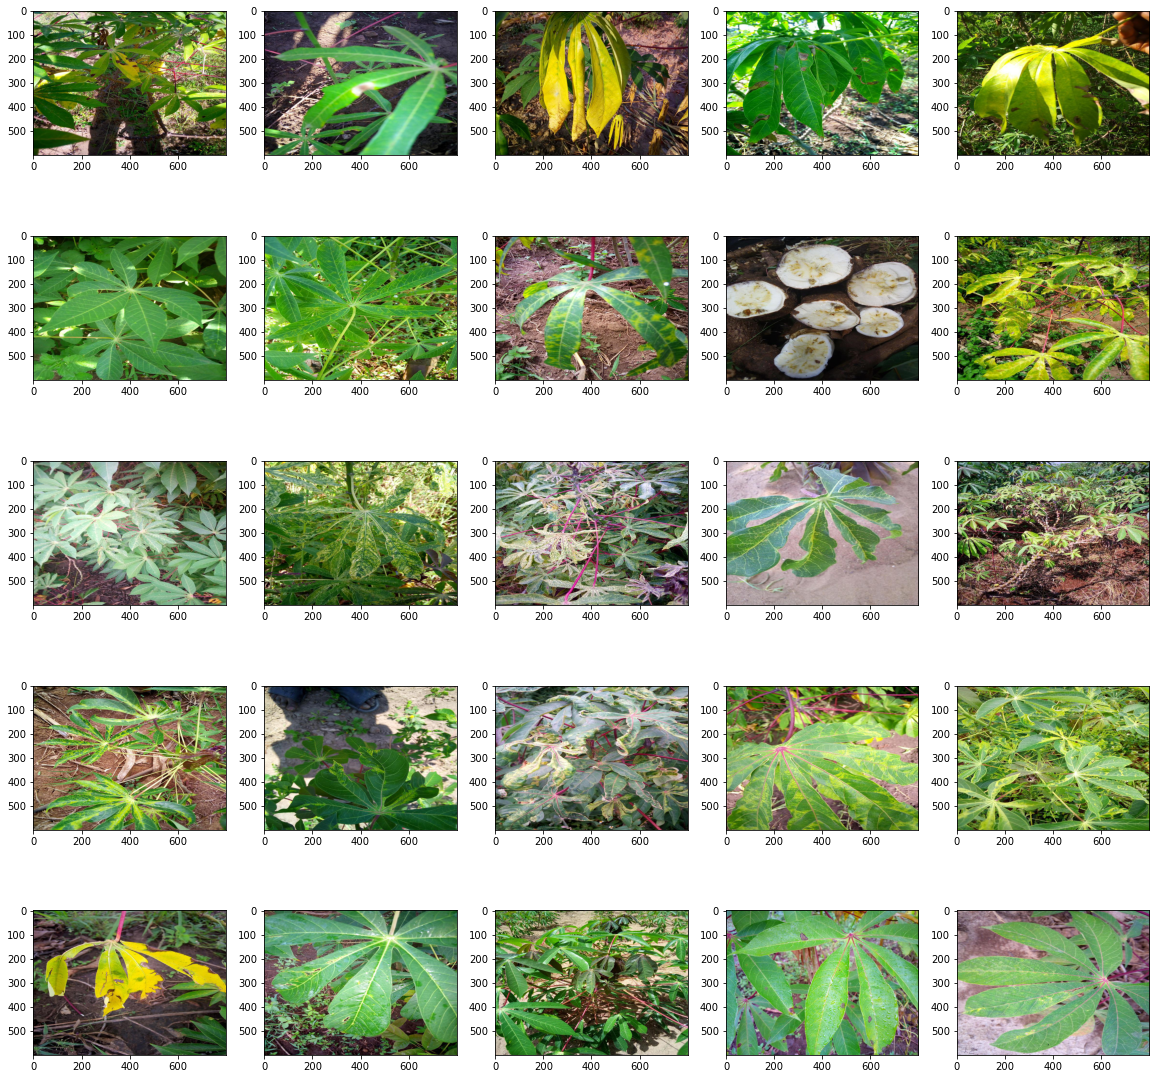

In [3]:

train_img_dir = os.path.join(root_dir, 'train_images')  

figure = plt.figure(figsize = (20,20))

cont = 0
    
for i in range(5):
    
    speci = train_df[train_df['label'] == i]
    
    for j in range(5):
        
        img = Image.open(os.path.join(train_img_dir, speci.iloc[j,0]))
        
        plt.subplot(5,5, cont+1)
        
        plt.imshow(img)
        
        cont = cont + 1

In [4]:

image_preprocessor = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomCrop(300,300),
    RandomTranslation(0.3, 0.3),
    RandomRotation(0.5),
    Rescaling(1./255)])

def custom_gen(batch_size, image_dir, h = 300, w = 300):
    
    start = 0
    end = batch_size
    images = train_df['image_id']
    labels = train_df['label']
    while 1:
        
        if end >= train_df.shape[0]:
            start = 0
            end = batch_size 
            continue
        else:
        
            batch = []

            if start == 0:
                names = images[:end]
                y = to_categorical(labels[:end], num_classes = 5)
            else:
                names = images[start:end]
                y = to_categorical(labels[start:end], num_classes = 5)

            for name in names:

                img = cv2.imread(os.path.join(image_dir,name))
                img = np.expand_dims(img, axis = 0)
                img = image_preprocessor(img)
                img = np.squeeze(img, axis = 0)
                batch.append(img)



            end = end + batch_size
            start = start +  batch_size


            yield np.array(batch), y
            
            
            
            

In [120]:
#densenet169_dir = "../input/allmodelwthih5/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5"
#base_dens = DenseNet169(weights = densenet169_dir, include_top = False, input_shape = (300, 300, 3))
#base_dens.trainable = False

In [104]:
#dens_base = create_base_model(base_dens)

In [8]:
# MobileNet Base Model creating NON trainable
mobilenet_weights_dir = '../input/allmodelwthih5/mobilenet_1_0_224_tf_no_top.h5'
base_mob = MobileNet(weights = mobilenet_weights_dir, include_top = False)
base_mob.trainable  = False

vgg19_weights_dir = "../input/allmodelwthih5/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_vgg19 = VGG19(weights = vgg19_weights_dir, include_top = False, input_shape = (300,300,3))
base_vgg19.trainable = False


# function to create a base model with standard output of 1024

def create_base_model(base_model):
    
    inputs = Input(shape = (300,300,3))
    
    base_out = base_model(inputs)
    
    base_out = Flatten()(base_out)
    
    base_out = Dropout(0.3)(base_out)
    
    base1_out = Dense(1024, activation = 'relu')(base_out)
    
    model = Model(inputs = inputs, outputs = base1_out)
    
    return model


vgg19_base = create_base_model(base_vgg19)

mob_base = create_base_model(base_mob)





def create_model(base1, base2):
    
    inputs = Input(shape = (300,300,3))
    
    base1_out = base1(inputs)
    base2_out = base2(inputs)

    base_out = add([base1_out, base2_out])
    
    outputs = Dense(512, activation = 'relu')(base_out)
    
    outputs = Dropout(0.2)(outputs)
    
    outputs = Dense(5, activation = 'softmax')(outputs)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    model.summary()

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
    mcp = ModelCheckpoint('model.h5')
    
    return model
    
    
model = create_model(mob_base, vgg19_base)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 1024)         88164544    input_11[0][0]                   
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1024)         62492736    input_11[0][0]                   
__________________________________________________________________________________________________
add (Add)                       (None, 1024)         0           model_3[1][0]                    
                                                                 model_2[1][0]              

In [10]:
batch_size = 64
epochs = 25
steps_per_epoch = train_df.shape[0] // batch_size
train_gen = custom_gen(batch_size, train_img_dir)

history = model.fit(train_gen, epochs = epochs, steps_per_epoch = steps_per_epoch )

Epoch 1/25
334/334 [==============================] - 575s 2s/step - loss: 0.7447
Epoch 2/25
334/334 [==============================] - 456s 1s/step - loss: 0.5276
Epoch 3/25
334/334 [==============================] - 455s 1s/step - loss: 0.3668
Epoch 4/25
334/334 [==============================] - 458s 1s/step - loss: 0.3022
Epoch 5/25
334/334 [==============================] - 470s 1s/step - loss: 0.2822
Epoch 6/25
334/334 [==============================] - 464s 1s/step - loss: 0.2017
Epoch 7/25
334/334 [==============================] - 464s 1s/step - loss: 0.1482
Epoch 8/25
334/334 [==============================] - 457s 1s/step - loss: 0.1209
Epoch 9/25
334/334 [==============================] - 443s 1s/step - loss: 0.1209
Epoch 10/25
334/334 [==============================] - 446s 1s/step - loss: 0.0920
Epoch 11/25
334/334 [==============================] - 464s 1s/step - loss: 0.0767
Epoch 12/25
334/334 [==============================] - 450s 1s/step - loss: 0.0675
Epoch 13/25
3

In [12]:
history.history.keys()

dict_keys(['loss'])

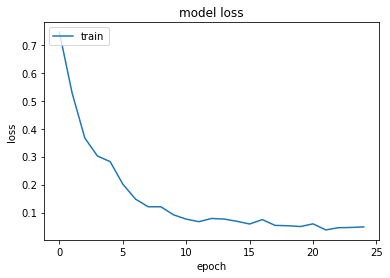

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [16]:
test_leaf = "../input/cassava-leaf-disease-classification/test_images"

test_names = pd.Series(os.listdir(test_leaf))


for j in range(3):

    for i in tqdm(range(len(test_names))):

        image = cv2.imread(os.path.join(test_leaf, test_names[i]))
        image = np.expand_dims(image, axis = 0)
        image = image_preprocessor(image)
        if i ==0:

            pred = model.predict(image)
        else:
            pred = np.concatenate([pred, model.predict(image)])
            
    if j ==0:
        final = pred
    else:
        final = final +pred
     
pred = pd.Series(np.argmax(final, axis = 1))


test_df = pd.concat([test_names, pred], axis = 1)
test_df = test_df.rename(columns = {0: 'image_id', 1: 'label'})

test_df.to_csv('submission.csv', index = False)

100%|██████████| 1/1 [00:00<00:00, 18.84it/s]
